# STENCIL-NET Simulation on Forced-Burgers equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

import sys
sys.path.append('D:\myProjects\diplom_2\GIT_stencil-net\GIT_stencil-net')

from stencilnet import MLPConv, forward_rk3_error, backward_rk3_error
from utils import burgers_simulation, forcing_terms, load_simulation_model
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Initialize Forcing Parameters

In [3]:
np.random.seed(0)

L = 2.0*np.pi; T_ = 40;  Al = -0.1; Ar = 0.1; wl = -0.4; wr = 0.4; N = 20
A = np.zeros((N,)); w = np.zeros((N,)); phi = np.zeros((N,)); l = np.zeros((N,))

for k in range(0, N):
    A[k] = (Ar-Al)*np.random.rand(1) + Al
    w[k] = (wr-wl)*np.random.rand(1) + wl
    phi[k] = (2.0*np.pi)*np.random.rand(1)
    l[k] = np.random.randint(2, 5)

C:\Users\tyxba\AppData\Local\Temp\ipykernel_20008\1990691078.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A[k] = (Ar-Al)*np.random.rand(1) + Al
C:\Users\tyxba\AppData\Local\Temp\ipykernel_20008\1990691078.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w[k] = (wr-wl)*np.random.rand(1) + wl
C:\Users\tyxba\AppData\Local\Temp\ipykernel_20008\1990691078.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi[k] = (2.0*np.pi)*np.random.rand(1)


## Generate Simulation Data using WENO and RK3

In [ ]:
Lx = 256; Tsim = 80001;
# Lx = 101; Tsim = 10001;
# Lx = 64; Tsim = 2001;
x = np.linspace(0,L,Lx); dx = x[1] - x[0]; D = 0.02; dt = 0.002

CFL = (dx*dx)/(2.0*D)
print("CFL dt", CFL, "actual dt", dt)

CFL dt 0.015178169013593782 actual dt 0.002


In [9]:
# ##generate (by WENO + RK3)
# v_fact, phase = burgers_simulation(Tsim, Lx, x, D, dt, A, w, phi, l, N, L)

import pickle
folder=fr'D:\myProjects\diplom_2\GIT_stencil-net\Experiments\Experiment_burgers_1/'


# ##save
# pickle.dump(v_fact, open(fr'{folder}/data/v_fact_n={Lx}_Tsim={Tsim}.pkl', 'wb'))
# pickle.dump(phase, open(fr'{folder}/data/phase_n={Lx}_Tsim={Tsim}.pkl', 'wb'))

##load
u=pickle.load( open(fr'{folder}/data/v_fact_n={Lx}_Tsim={Tsim}.pkl', 'rb'))
phase=pickle.load( open(fr'{folder}/data/phase_n={Lx}_Tsim={Tsim}.pkl', 'rb'))

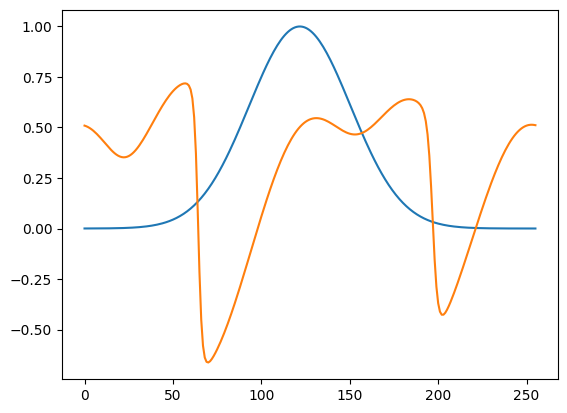

In [10]:
plt.plot(u[:,0])
plt.plot(u[:,-1])

## Subsample Solution Data

In [11]:
t_factor = 20  # time subsample factor 
s_factor = 4   # space subsample factor

# t_factor=1
# s_factor=1

dxc = s_factor*dx
dtc = t_factor*dt

CFLc = D*dtc/(dxc*dxc)
print("coarse CFL condition", CFLc, "coarse dt", dtc)

coarse_t = np.arange(0, Tsim, t_factor)
coarse_x = np.arange(0, Lx, s_factor)

u_coarse = np.zeros((len(coarse_x),len(coarse_t)))
phase_coarse = np.zeros((len(coarse_x),len(coarse_t)))
for i,_x in enumerate(coarse_t):
    u_coarse[:,i] = u[coarse_x,coarse_t[i]].real
    phase_coarse[:,i] = phase[coarse_x,coarse_t[i]].real  

coarse CFL condition 0.08235512457928769 coarse dt 0.04


In [12]:
u_coarse.shape

(64, 4001)

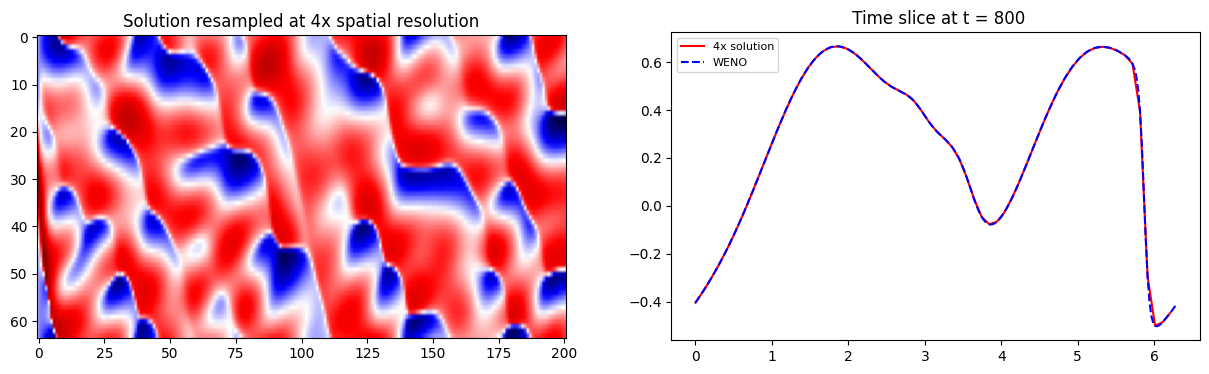

In [27]:
time = 800

plt.subplot(1,2,1)
plt.title("Solution resampled at " + str(s_factor) + "x spatial resolution")
plt.imshow(u_coarse[:,np.arange(0,u_coarse.shape[1],20)],cmap='seismic', aspect=1.8)

plt.subplot(1,2,2)
plt.title(" Time slice at t = " + str(time))
plt.plot(x[coarse_x], u_coarse[:,time],'-',color='red',label=str(s_factor) + 'x solution')
plt.plot(x, u[:,t_factor*time],'--',color='blue',label='WENO')
plt.legend(loc='best', prop={'size':8})
plt.gcf().set_size_inches(15,4)

In [28]:
# define training data
u_coarse_train = u_coarse[:, :1001]
Lxc, Ltc = u_coarse_train.shape

## Training or Load Pre-trained Model

You may choose to run the training procedure yourself (~1h depending on data size) or load one of the already pre-trained models below.

### Train Model

In [29]:
# initialize the different forcing terms at current timestep,
# half and full timestep into past (m) and future (p)
Fc, Fc_0p5, Fc_p1, Fc_0m5, Fc_m1 = forcing_terms(A, w, phi, l, L, Lxc, T_, Ltc, N, dtc)

u_train = torch.tensor(u_coarse_train.T, requires_grad=True, dtype=torch.float, device=device)
fc      = torch.tensor(Fc.T, requires_grad=True, dtype=torch.float, device=device)
fc_0p5  = torch.tensor(Fc_0p5.T, requires_grad=True, dtype=torch.float, device=device)
fc_p1   = torch.tensor(Fc_p1.T, requires_grad=True, dtype=torch.float, device=device)
fc_0m5  = torch.tensor(Fc_0m5.T, requires_grad=True, dtype=torch.float, device=device)
fc_m1   = torch.tensor(Fc_m1.T, requires_grad=True, dtype=torch.float, device=device)

In [30]:
fc_m1

tensor([[-0.1426, -0.1529, -0.1494,  ..., -0.0999, -0.1231, -0.1426],
        [-0.1414, -0.1525, -0.1497,  ..., -0.0975, -0.1212, -0.1414],
        [-0.1401, -0.1520, -0.1501,  ..., -0.0951, -0.1193, -0.1401],
        ...,
        [ 0.1136,  0.0773,  0.0230,  ...,  0.1247,  0.1291,  0.1136],
        [ 0.1125,  0.0764,  0.0223,  ...,  0.1237,  0.1280,  0.1125],
        [ 0.1114,  0.0755,  0.0217,  ...,  0.1227,  0.1269,  0.1114]],
       requires_grad=True)

In [18]:
seed = 1

np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# size of filter to be applied
fs = 7

net       = MLPConv([fs, 32, 32, 32, 1], seed=seed, fs=fs, activation=nn.ELU()).to(device)
params    = [{'params': net.parameters(), 'lr': 1e-3}]
optimizer = Adam(params)
scheduler = ExponentialLR(optimizer, .9998)

print("#parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))

# number of timesteps to be predicted during training 
m = 4 

# decaying weights for accumulating prediction error
decay_const = 0.9
output_weights = [decay_const**j for j in range(m+1)] 
wd = torch.tensor(output_weights, dtype=torch.float32, device=device)

epochs = 100
l_wd   = 1e-7

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    
    # compute forward and backward prediction errors
    fwd = forward_rk3_error(net, u_train, dtc, m, wd, fc=fc, fc_0p5=fc_0p5, fc_p1=fc_p1)
    bwd = backward_rk3_error(net, u_train, dtc, m, wd, fc=fc, fc_0m5=fc_0m5, fc_m1=fc_m1)
    
    # compute norm of weights
    res_w = 0
    for i in range(len(net.layer)):
        W = net.layer[i].weight
        W = W.view(W.shape[0]*W.shape[1], -1)
        res_w = res_w + (torch.norm(W, p=2, dim=0)**2)
        
    loss =  fwd + bwd + l_wd*res_w
    
    loss.backward()
    optimizer.step()
    
    if epoch > 15_000:
        scheduler.step()
        
    
torch.save(net, './models/model_forced_burgers_' + str(fs) + "_"+str(3) +'L_' + str(32) + '_ep_' + str(epochs)  + '_' + "elu" + '_m' + str(m) + '_Lxc' +  str(s_factor) + "_Ltc" + str(t_factor) +  '_lwd' + str(l_wd) +'_WDactRK3_seed_'+ str(seed)  + '.pth')

input 7 output 32
input 32 output 32
input 32 output 32
input 32 output 1
#parameters: 2401


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


In [19]:
neurons = 32

net = load_simulation_model(s_factor, t_factor, neurons, device)

## Simulation using STENCIL-NET

In [20]:
Lx_sim = int(Lx/s_factor)
x_sim  = np.linspace(0,L,Lx_sim)
dxs    = x_sim[1] - x_sim[0]
dts    = dtc
T_sim  = 4001

NN_sim   = np.zeros((Lx_sim,T_sim))
phase_NN = np.zeros((Lx_sim,T_sim))

NN_sim[:,0] = np.exp(-(x_sim-3)**2)
# NN_sim[:,0] = u_coarse[:,0]#np.exp(-(x_sim-3)**2)

zf   = 0
time = 0
for j in tqdm(range(0,T_sim-1)):
    tensor = NN_sim[:,j].reshape(1,Lxc)
    torch_tensor = torch.tensor(tensor,dtype=torch.float,device=device)
    
    forcing = np.zeros((Lx_sim,))
    for k in range(0, N):
        forcing = forcing + A[k]*np.sin(w[k]*time + 2.0*np.pi*l[k]*(x_sim/L) + phi[k])
    
    phase_NN[:,j] = net(torch_tensor).cpu().data.numpy()
    k1   =  dts*phase_NN[:,j] + dts*forcing
    temp =  NN_sim[:,j] + 0.5*k1 
    
    tensor = temp.reshape(1,Lxc)
    torch_tensor = torch.tensor(tensor,dtype=torch.float,device=device)
    
    forcing = np.zeros((Lx_sim,))
    for k in range(0, N):
        forcing = forcing + A[k]*np.sin(w[k]*(time+0.5*dts) + 2.0*np.pi*l[k]*(x_sim/L) + phi[k])

    k2   =  dts*net(torch_tensor).cpu().data.numpy() + dts*forcing
    temp =  NN_sim[:,j] - k1 + 2.0*k2
    
    tensor = temp.reshape(1,Lxc)
    torch_tensor = torch.tensor(tensor,dtype=torch.float,device=device)
    
    forcing = np.zeros((Lx_sim,))
    for k in range(0, N):
        forcing = forcing + A[k]*np.sin(w[k]*(time+dts) + 2.0*np.pi*l[k]*(x_sim/L) + phi[k])

    k3   =  dts*net(torch_tensor).cpu().data.numpy() + dts*forcing
    
    NN_sim[:,j+1] = NN_sim[:,j] + (1./6.)*(k1 + 4.0*k2 + k3)
    
    time = time + dts

100%|██████████| 4000/4000 [00:06<00:00, 643.06it/s]


In [21]:
u_coarse

array([[ 1.23409804e-04, -5.56730060e-03, -1.11809241e-02, ...,
         5.13751022e-01,  5.11525972e-01,  5.09284494e-01],
       [ 2.20777443e-04, -5.83885834e-03, -1.18404017e-02, ...,
         4.95374370e-01,  4.93045116e-01,  4.90705609e-01],
       [ 3.87366657e-04, -5.58083791e-03, -1.15057316e-02, ...,
         4.63044915e-01,  4.60739548e-01,  4.58431740e-01],
       ...,
       [ 1.14719198e-04, -3.08638159e-03, -6.20076756e-03, ...,
         4.72225440e-01,  4.70760220e-01,  4.69267313e-01],
       [ 6.27413387e-05, -4.04789565e-03, -8.07069075e-03, ...,
         5.04322167e-01,  5.02535666e-01,  5.00723999e-01],
       [ 3.36537885e-05, -4.99987995e-03, -9.94214473e-03, ...,
         5.17380097e-01,  5.15338037e-01,  5.13274614e-01]],
      shape=(64, 4001))

In [22]:
NN_sim

array([[ 1.23409804e-04, -6.75090672e-03, -1.35375850e-02, ...,
        -1.21841272e+09, -1.23074152e+09, -1.24307465e+09],
       [ 2.22285472e-04, -7.07758507e-03, -1.42696405e-02, ...,
         1.51403858e+09,  1.51134794e+09,  1.50850737e+09],
       [ 3.92493899e-04, -6.79047417e-03, -1.38752666e-02, ...,
         3.46718550e+08,  3.67834914e+08,  3.89062294e+08],
       ...,
       [ 7.41571898e-05, -5.04984169e-03, -1.00895132e-02, ...,
        -8.29646594e+08, -8.43129539e+08, -8.56733508e+08],
       [ 3.96917201e-05, -6.03084569e-03, -1.20134977e-02, ...,
         1.73469317e+09,  1.73786930e+09,  1.74087953e+09],
       [ 2.08260540e-05, -6.87014819e-03, -1.37013324e-02, ...,
        -5.17881220e+08, -4.98845520e+08, -4.79632167e+08]],
      shape=(64, 4001))

In [23]:
u_coarse.shape,NN_sim.shape

((64, 4001), (64, 4001))

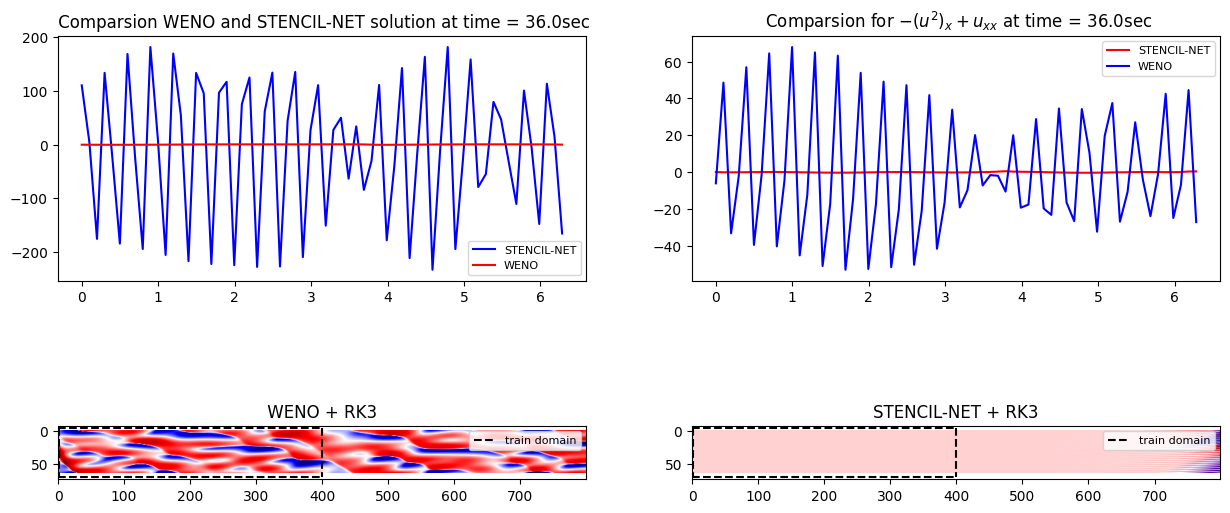

In [24]:
time = 900

plt.subplot(2,2,1)
plt.title(" Comparsion WENO and STENCIL-NET solution at time = " + str(time*dtc) + "sec")
plt.plot(x_sim,NN_sim[:,time],'-',color='blue',label='STENCIL-NET')
plt.plot(x_sim,u_coarse[:,time],color='red', label='WENO')
plt.legend(loc='best', prop={'size':8})

plt.subplot(2,2,2)
plt.title(" Comparsion for $ -(u^2)_x +  u_{xx} $ at time = " +  str(time*dtc) + "sec")
plt.plot(x_sim, phase_coarse[:,time],color='red',label='STENCIL-NET')
plt.plot(x_sim, phase_NN[:,time],'-',color='blue',label='WENO')
plt.legend(loc='best', prop={'size':8})

max_time = 4000

train_boundary=NN_sim[:,np.arange(0,max_time,5)].shape[1]*0.5

plt.subplot(2,2,3)
plt.title(" WENO + RK3 ")
plt.imshow(u_coarse[:,np.arange(0,max_time,5)], cmap='seismic')
plt.vlines(train_boundary, -5, Lx_sim+5,color='black',linestyles='dashed', label='train domain')
plt.vlines(1, -5, Lx_sim+5,color='black',linestyles='dashed')
plt.hlines(Lx_sim+5, 0, train_boundary,color='black',linestyles='dashed')
plt.hlines(-5, 0, train_boundary,color='black',linestyles='dashed')
plt.legend(loc='best', prop={'size':8})

plt.subplot(2,2,4)
plt.title("STENCIL-NET + RK3")
plt.imshow(NN_sim[:,np.arange(0,max_time,5)], cmap='seismic', )
plt.vlines(train_boundary, -5, Lx_sim+5,color='black',linestyles='dashed', label='train domain')
plt.vlines(1, -5, Lx_sim+5,color='black',linestyles='dashed')
plt.hlines(Lx_sim+5, 0, train_boundary,color='black',linestyles='dashed')
plt.hlines(-5, 0, train_boundary,color='black',linestyles='dashed')
plt.legend(loc='best', prop={'size':8})

plt.gcf().set_size_inches(15,7)

In [ ]:
time = 2000

plt.subplot(2,2,1)
plt.title(" Comparsion WENO and STENCIL-NET solution at time = " + str(time*dtc) + "sec")
plt.plot(x_sim,NN_sim[:,time],'-',color='blue',label='STENCIL-NET')
plt.plot(x_sim,u_coarse[:,time],color='red', label='WENO')
plt.legend(loc='best', prop={'size':8})

plt.subplot(2,2,2)
plt.title(" Comparsion for $ -(u^2)_x +  u_{xx} $ at time = " +  str(time*dtc) + "sec")
plt.plot(x_sim, phase_coarse[:,time],color='red',label='STENCIL-NET')
plt.plot(x_sim, phase_NN[:,time],'-',color='blue',label='WENO')
plt.legend(loc='best', prop={'size':8})

In [ ]:
train_boundary